#LSTM Model for Product Description Generator

## 1. Import packages and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import requests
import tensorflow as tf
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, Bidirectional,
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import os
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from PIL import Image
from io import BytesIO

In [ ]:
# read data_processed.csv
data_path = '/content/drive/MyDrive/BT5153/Data/'
df = pd.read_csv('/content/drive/MyDrive/BT5153/Data/Data_processed_reduced_v4.csv',encoding= 'unicode_escape')
df.shape

(18680, 11)

In [ ]:
# add img paths
df['img_path'] = df.img_id.apply(lambda x: '/content/drive/MyDrive/BT5153/Data/Pict/' + str(x) + '.jpg')
df.head()

,Unnamed: 0,img_id,title,img_url,description,sex,material,price,brand,colour,Description,img_path
0,0,0,MEN Linen Blended Shorts,https://d15udtvdbbfasl.cloudfront.net/catalog/...,a single layer with a natural feel of natural ...,MEN,"68% Cotton, 32% Linen",29.9,UNIQLO,Color: COL69 NAVY,a single layer with a natural feel of natural ...,/content/drive/MyDrive/BT5153/Data/Pict/0.jpg
1,1,1,MEN Easy Shorts (Printed),https://d15udtvdbbfasl.cloudfront.net/catalog/...,light and cool shorts are perfect for relaxing...,MEN,100% Cotton,19.9,UNIQLO,Color: COL37 BROWN,light and cool shorts are perfect for relaxing...,/content/drive/MyDrive/BT5153/Data/Pict/1.jpg
2,2,2,MEN Chino Shorts,https://d15udtvdbbfasl.cloudfront.net/catalog/...,updated to have a relaxed silhouette has a mor...,MEN,100% Cotton,29.9,UNIQLO,Color: COL09 BLACK,updated to have a relaxed silhouette has a mor...,/content/drive/MyDrive/BT5153/Data/Pict/2.jpg
3,3,3,MEN Uniqlo U Wide Fit Easy Shorts,https://d15udtvdbbfasl.cloudfront.net/catalog/...,shorts inspired by military pants trendy loose...,MEN,100% Cotton,49.9,UNIQLO,Color: COL09 BLACK,shorts inspired by military pants trendy loose...,/content/drive/MyDrive/BT5153/Data/Pict/3.jpg
4,5,5,MEN Ultra Light Shorts,https://d15udtvdbbfasl.cloudfront.net/catalog/...,kando shorts has been renamed to ultra light s...,MEN,100% Polyester,39.9,UNIQLO,Color: COL32 BEIGE,kando shorts has been renamed to ultra light s...,/content/drive/MyDrive/BT5153/Data/Pict/5.jpg


In [ ]:
# Export training and validation sets
#df_train = df.sample(frac=0.8, random_state=123)
#df_validation = df.loc[~df.index.isin(df_train.index)]
#df_train = df_train.reset_index(drop=True)
#df_validation = df_validation.reset_index(drop=True)

#df_train.to_csv('/content/drive/MyDrive/BT5153/Data/df_train_v4.csv', index=None)
#df_validation.to_csv('/content/drive/MyDrive/BT5153/Data/df_validation_v4.csv', index=None)

31.003693790149892


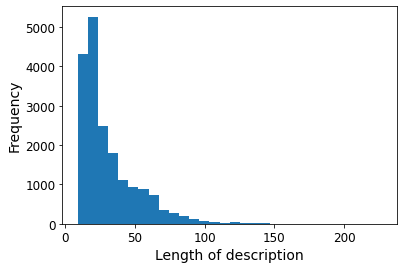

In [ ]:
df['text_length'] = df['description'].apply(lambda x: len(x.split()))
print(df['text_length'].mean())
df['text_length'].plot.hist(bins=30)
plt.xlabel('Length of description', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

## 2. Model Building

In [ ]:
# padding 'ss' and 'ee' to the string to mark the begining and end
df['description'] = df['description'].apply(lambda x: 'ss '+ x + ' ee' )

In [ ]:
#  build vocabulary using glove and vectorize the text
max_tokens = 10000
output_sequence_length=62
vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_sequence_length, standardize=None)
text_ds = df.description.values
vectorizer.adapt(text_ds) 
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
index_word = dict(zip(range(len(voc)), voc))
embeddings_index = {}
with open(data_path + "glove.6B.50d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
num_tokens = len(voc) 
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 8362 words (560 misses)


In [ ]:
embedding_matrix.shape

(8922, 50)

In [ ]:
# define function to load image and preprocess to the format compatible with inceptionv3
import cv2
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img

In [ ]:
# define InceptionV3 image feature extraction model 
image_model = tf.keras.applications.InceptionV3(include_top=True,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
def data_preprocess(feature,text):
  x1,x2,y=[],[],[]
  for i in range(len(feature)):
    for j in range(len(text)-1):
      x1.append(feature)
      x2.append(pad_sequences(np.array([text[:j+1]]).reshape(1,-1),maxlen=output_sequence_length,padding='post',truncating='pre'))
      y.append(to_categorical([text[j+1]], num_classes=num_tokens)[0])
  return x1,x2,y

def batch_process(features,texts):
  x1=[]
  x2=[]
  y=[]
  for i,j in zip(features,texts):
    fe,txt,label = data_preprocess(i,j)
    x1+=fe
    x2+=txt
    y+=label
  return x1,x2,y

In [ ]:
class Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, df, batch_size) :
    self.paths = df.img_path.values
    self.descriptions = df.description.values
    self.batch_size = batch_size  
    self.on_epoch_end()
    
  def __len__(self) :
    return (np.ceil(len(self.paths) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    images = np.array([load_image(path) for path in self.paths[idx * self.batch_size : (idx+1) * self.batch_size]])
    image_features = image_features_extract_model(images)
    image_features = tf.reshape(image_features,
                              (image_features.shape[0], -1,image_features.shape[1]))
    texts = np.array(self.descriptions[idx * self.batch_size : (idx+1) * self.batch_size])
    texts = vectorizer(texts)
    x1,x2,y = batch_process(image_features,texts)
    x1 = tf.convert_to_tensor(x1)
    x1=tf.reshape(x1, (x1.shape[0],x1.shape[2]))
    x2 = tf.convert_to_tensor(x2)
    x2=tf.reshape(x2, (x2.shape[0],x2.shape[2]))
    y = tf.convert_to_tensor(y)
    return [x1,x2], y

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 62, 50)       446100      input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           102450      input_1[0][0]                    
______________________________________________________________________________________________

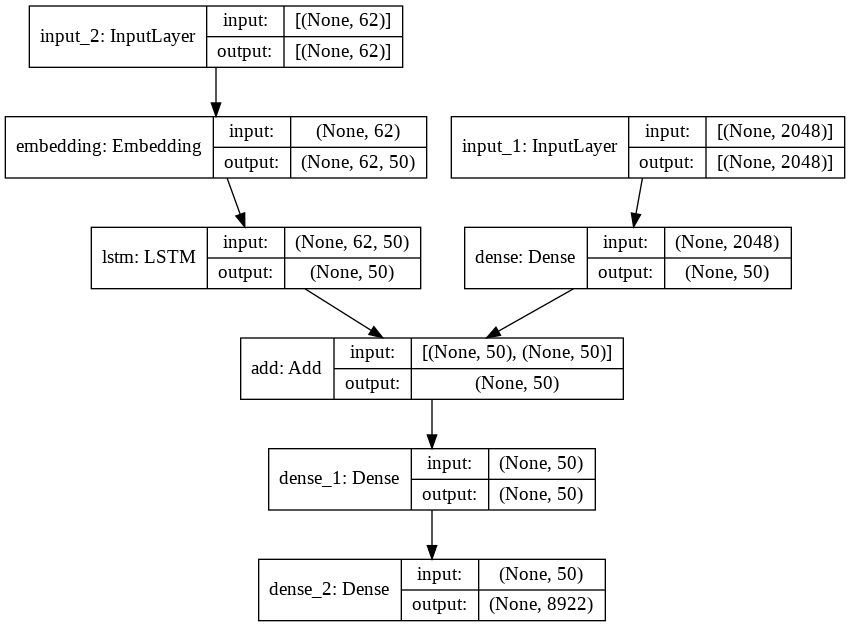

In [ ]:
max_length=62
with tf.device('/device:CPU:0'):
#with tf.device('/device:GPU:0'):
  OUTPUT_DIM=2048

  embedding_layer = Embedding(num_tokens, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False)

  inputs1 = Input(shape=(OUTPUT_DIM,))
  fe1 = Dense(embedding_dim, activation='relu')(inputs1)
  inputs2 = Input(shape=(max_length,))
  se1 = embedding_layer(inputs2)
  se2 = LSTM(embedding_dim)(se1)
  decoder1 = add([fe1, se2])
  decoder2 = Dense(embedding_dim, activation='relu')(decoder1)
  outputs = Dense(num_tokens, activation='softmax')(decoder2)
  caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  opt = Adam(learning_rate=0.01)

  # Checkpoint
  checkpoint_filepath = '/content/drive/MyDrive/BT5153/Codes/checkpoint_models_lstmv2_zt/checkpoint_models/checkpoint_lstm_zt.ckpt'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_loss',
      mode='min',
      save_best_only=True)

  # Early Stopping
  earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True, mode='min')

  caption_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

caption_model.summary()
plot_model(caption_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
df_train = df.sample(frac=0.8, random_state=123)
df_validation = df.loc[~df.index.isin(df_train.index)]
df_train = df_train.reset_index()
df_validation = df_validation.reset_index()
print ("train size : ", df_train.shape[0])
print ("validation size : ", df_validation.shape[0])
BATCH_SIZE = 20
train_generator = Generator(df_train, BATCH_SIZE)
validation_generator = Generator(df_validation, BATCH_SIZE)

train size :  14944
validation size :  3736


## 3. Model Training

In [ ]:
# Model Training (2 epochs)
caption_model.fit(train_generator, 
                  validation_data=validation_generator, 
                  epochs=10, 
                  verbose=1, 
                  callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/10
748/748 [==============================] - 15287s 20s/step - loss: 3.2619 - accuracy: 0.5281 - val_loss: 2.8176 - val_accuracy: 0.5359
Epoch 2/10
748/748 [==============================] - 2982s 4s/step - loss: 2.7612 - accuracy: 0.5404 - val_loss: 2.5846 - val_accuracy: 0.5576
Epoch 3/10
 65/748 [=>............................] - ETA: 36:06 - loss: 2.4618 - accuracy: 0.5713

In [ ]:
# Load weights from 2nd epoch and resume model training (3rd-4th epoch)
# weights from 4th epoch was saved
prev_checkpoint = '/content/drive/MyDrive/BT5153/Codes/checkpoint_models_lstmv2_zt/lstm_2nd_epoch/checkpoint_lstm_zt.ckpt'
caption_model.load_weights(prev_checkpoint)
caption_model.fit(train_generator, 
                  validation_data=validation_generator, 
                  epochs=10, 
                  verbose=1, 
                  callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/10
748/748 [==============================] - 10841s 14s/step - loss: 2.4666 - accuracy: 0.5768 - val_loss: 2.2747 - val_accuracy: 0.6080
Epoch 2/10
748/748 [==============================] - 7448s 10s/step - loss: 2.2080 - accuracy: 0.6165 - val_loss: 2.1591 - val_accuracy: 0.6332
Epoch 3/10
181/748 [======>.......................] - ETA: 1:14:48 - loss: 2.0885 - accuracy: 0.6364

In [ ]:
# Load weights from 4th epoch and resume model training (5th - 14th epoch)
prev_checkpoint = '/content/drive/MyDrive/BT5153/Codes/checkpoint_models_lstmv2_zt/lstm_4th_epoch/checkpoint_lstm_zt.ckpt'
caption_model.load_weights(prev_checkpoint)
caption_model.fit(train_generator, 
                  validation_data=validation_generator, 
                  epochs=10, 
                  verbose=1, 
                  callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/10
748/748 [==============================] - 7783s 10s/step - loss: 2.1017 - accuracy: 0.6343 - val_loss: 2.0942 - val_accuracy: 0.6433
Epoch 2/10
748/748 [==============================] - 2345s 3s/step - loss: 1.9999 - accuracy: 0.6477 - val_loss: 2.0275 - val_accuracy: 0.6521
Epoch 3/10
748/748 [==============================] - 2356s 3s/step - loss: 1.9557 - accuracy: 0.6540 - val_loss: 1.9949 - val_accuracy: 0.6590
Epoch 4/10
748/748 [==============================] - 2355s 3s/step - loss: 1.9046 - accuracy: 0.6626 - val_loss: 1.9600 - val_accuracy: 0.6670
Epoch 5/10
748/748 [==============================] - 2357s 3s/step - loss: 1.8550 - accuracy: 0.6697 - val_loss: 1.9377 - val_accuracy: 0.6711
Epoch 6/10
748/748 [==============================] - 2352s 3s/step - loss: 1.8232 - accuracy: 0.6741 - val_loss: 1.9041 - val_accuracy: 0.6742
Epoch 7/10
748/748 [==============================] - 2363s 3s/step - loss: 1.8025 - accuracy: 0.6764 - val_loss: 1.9153 - val_accuracy

In [ ]:
# Load weights from 14th epoch and resume model training (15th - 16th epoch)
# val loss and val accuracy are plateauing
prev_checkpoint = '/content/drive/MyDrive/BT5153/Codes/checkpoint_models_lstmv2_zt/lstm_14th_epoch/checkpoint_lstm_zt.ckpt'
caption_model.load_weights(prev_checkpoint)
caption_model.fit(train_generator, 
                  validation_data=validation_generator, 
                  epochs=8, 
                  verbose=1, 
                  callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/8
748/748 [==============================] - 12092s 16s/step - loss: 1.6925 - accuracy: 0.6904 - val_loss: 1.8826 - val_accuracy: 0.6819
Epoch 2/8
748/748 [==============================] - 5912s 8s/step - loss: 1.7091 - accuracy: 0.6866 - val_loss: 1.8637 - val_accuracy: 0.6847
Epoch 3/8
372/748 [=============>................] - ETA: 39:54 - loss: 1.6867 - accuracy: 0.6902

**Load final trained model**

In [ ]:
# Load weights from 16th epoch
best_checkpoint = '/content/drive/MyDrive/BT5153/Codes/checkpoint_models_lstmv2_zt/lstm_16th_epoch/checkpoint_lstm_zt.ckpt'
caption_model.load_weights(best_checkpoint)

## 4. Generate captions using trained model

In [ ]:
# define function to generate description from image
def generateCaption(img_path):
  photo = load_image(img_path)
  photo = tf.reshape(photo,(1,photo.shape[0],photo.shape[1],photo.shape[2]))
  photo = image_features_extract_model(photo)

  in_text = 'ss'
  for i in range(32):
      sequence = np.array([word_index[w] for w in in_text.split() if w in word_index])
      sequence = pad_sequences([sequence], maxlen=max_length,padding='post')
      yhat = caption_model.predict([photo,sequence], verbose=0)
      yhat = np.argmax(yhat)
      word = index_word[yhat]
      in_text += ' ' + word
      if word =='ee':
          break
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

Generated: a pair of knit shorts featuring a high rise waist and a cropped hem
Actual: ss light and cool shorts are perfect for relaxing convenient pockets for carrying small items pockets have a new shape waist spindle is now on the inside tonal color leaf print ee
Product name: MEN Easy Shorts (Printed)
BLEU-1 score: 9.111615923542011
BLEU-2 score: 10.019220966972737
BLEU-3 score: 10.588303042182682
BLEU-4 score: 8.554662675966664


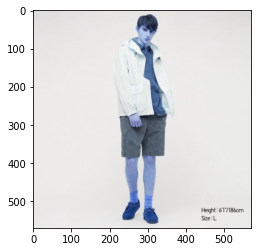

In [ ]:
# Example 1
final = generateCaption(df_validation.iloc[0]['img_path'])
actual = df_validation.iloc[0]['description']
img = cv2.imread(df_validation.iloc[0]['img_path'])
plt.imshow(img)
print('Generated: {}'.format(final))
print('Actual: {}'.format(actual))
print('Product name: {}'.format(df_validation.iloc[0]['title']))

# prepare reference and candidate lists for BLEU score calculation
candidate = final.split()
reference = actual.split()[1:-1]

# calculate BLEU scores
score = sentence_bleu([reference], candidate, weights=(1.0,0,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.5,0.5,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.3,0.3,0.3,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-4 score: {score*100}")

Generated: a knit tee featuring a front graphic of the text of the text of the text of the text of the text of the text of the text of the text
Actual: ss this flannel shirt gives a man a stylish and masculine look ee
Product name: Flannel shirt - slim fit - button-down collar - check
BLEU-1 score: 6.451612903225806
BLEU-2 score: 16.2075368726831
BLEU-3 score: 23.134324999129653
BLEU-4 score: 20.322489980918345


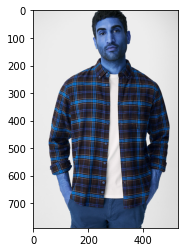

In [ ]:
# Example 2
final = generateCaption(df_validation.iloc[500]['img_path'])
actual = df_validation.iloc[500]['description']
img = cv2.imread(df_validation.iloc[500]['img_path'])
plt.imshow(img)
print('Generated: {}'.format(final))
print('Actual: {}'.format(df_validation.iloc[500]['description']))
print('Product name: {}'.format(df_validation.iloc[500]['title']))

# prepare reference and candidate lists for BLEU score calculation
candidate = final.split()
reference = actual.split()[1:-1]

# calculate BLEU scores
score = sentence_bleu([reference], candidate, weights=(1.0,0,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.5,0.5,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.3,0.3,0.3,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-4 score: {score*100}")

Generated: a woven mini dress featuring a v neckline and a bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon bodycon
Actual: ss subdued colour blocks and a delicate shiny finish gives this relaxed dress a modern twist ee
Product name: Dress - striped - recycled
BLEU-1 score: 12.903225806451616
BLEU-2 score: 6.558258357839532
BLEU-3 score: 13.443109440907158
BLEU-4 score: 12.927444134338966


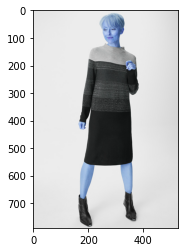

In [ ]:
# Example 3
final = generateCaption(df_validation.iloc[1000]['img_path'])
actual = df_validation.iloc[1000]['description']
img = cv2.imread(df_validation.iloc[1000]['img_path'])
plt.imshow(img)
print('Generated: {}'.format(final))
print('Actual: {}'.format(actual))
print('Product name: {}'.format(df_validation.iloc[1000]['title']))

# prepare reference and candidate lists for BLEU score calculation
candidate = final.split()
reference = actual.split()[1:-1]

# calculate BLEU scores
score = sentence_bleu([reference], candidate, weights=(1.0,0,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.5,0.5,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.3,0.3,0.3,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-4 score: {score*100}")

Generated: a knit top featuring a v neckline short sleeves and a cropped hem
Actual: ss a hacci knit sweater featuring a v neckline long raglan balloon sleeves curved hem and an oversized fit ee
Product name: Raglan Balloon-Sleeve Sweater
BLEU-1 score: 47.12624296084976
BLEU-2 score: 28.319347569219616
BLEU-3 score: 24.117184382734933
BLEU-4 score: 16.122514636832644


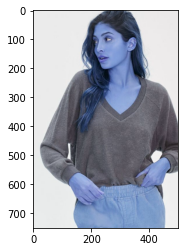

In [ ]:
# Example 4
final = generateCaption(df_validation.iloc[1976]['img_path'])
actual = df_validation.iloc[1976]['description']
img = cv2.imread(df_validation.iloc[1976]['img_path'])
plt.imshow(img)
print('Generated: {}'.format(final))
print('Actual: {}'.format(actual))
print('Product name: {}'.format(df_validation.iloc[1976]['title']))

# prepare reference and candidate lists for BLEU score calculation
candidate = final.split()
reference = actual.split()[1:-1]

# calculate BLEU scores
score = sentence_bleu([reference], candidate, weights=(1.0,0,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.5,0.5,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.3,0.3,0.3,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-4 score: {score*100}")

Generated: these jeans are a fashionable look and fashionable garment effects
Actual: ss classic that belongs in every wardrobe straight leg jeans in an authentic vintage look ee
Product name: THE STRAIGHT JEANS
BLEU-1 score: 13.406400920712787
BLEU-2 score: 16.83320204872465
BLEU-3 score: 19.06014112989535
BLEU-4 score: 15.586498959767406


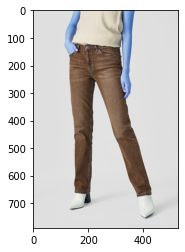

In [ ]:
# Example 5
final = generateCaption(df_validation.iloc[854]['img_path'])
actual = df_validation.iloc[854]['description']
img = cv2.imread(df_validation.iloc[854]['img_path'])
plt.imshow(img)
print('Generated: {}'.format(final))
print('Actual: {}'.format(actual))
print('Product name: {}'.format(df_validation.iloc[854]['title']))

# prepare reference and candidate lists for BLEU score calculation
candidate = final.split()
reference = actual.split()[1:-1]

# calculate BLEU scores
score = sentence_bleu([reference], candidate, weights=(1.0,0,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.5,0.5,0,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.3,0.3,0.3,0), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu([reference], candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function=SmoothingFunction().method4)
print(f"BLEU-4 score: {score*100}")

**Generate all captions and compute BLEU scores**

In [ ]:
# Define empty dataframe to store BLEU scores
val_lstm_bleu = pd.DataFrame(columns=['img_id', 'img_path', 'real_caption', 'predicted_caption', 'bleu_1', 'bleu_2', 'bleu_3', 'bleu_4'])
val_lstm_bleu

,img_id,img_path,real_caption,predicted_caption,bleu_1,bleu_2,bleu_3,bleu_4


In [ ]:
# Compute BLEU scores for validation set
for i in range(len(df_validation)):
  
  # Obtain predicted caption
  pred_caption = generateCaption(df_validation.iloc[i]['img_path'])

  # Compute BLEU scores
  actual_caption = df_validation.iloc[i]['description']
  candidate = pred_caption.split()
  reference = actual_caption.split()[1:-1] # remove start and ending tokens

  score1 = sentence_bleu([reference], candidate, weights=(1.0,0,0,0), smoothing_function=SmoothingFunction().method4)
  score2 = sentence_bleu([reference], candidate, weights=(0.5,0.5,0,0), smoothing_function=SmoothingFunction().method4)
  score3 = sentence_bleu([reference], candidate, weights=(0.3,0.3,0.3,0), smoothing_function=SmoothingFunction().method4)
  score4 = sentence_bleu([reference], candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function=SmoothingFunction().method4)
  
  # Fill up dataframe
  print(i) # check progress
  val_lstm_bleu.loc[i, 'img_id'] = df_validation.iloc[i]['img_id']
  val_lstm_bleu.loc[i, 'img_path'] = df_validation.iloc[i]['img_path']
  val_lstm_bleu.loc[i, 'real_caption'] = actual_caption
  val_lstm_bleu.loc[i, 'predicted_caption'] = pred_caption
  val_lstm_bleu.loc[i, 'bleu_1'] = score1
  val_lstm_bleu.loc[i, 'bleu_2'] = score2
  val_lstm_bleu.loc[i, 'bleu_3'] = score3
  val_lstm_bleu.loc[i, 'bleu_4'] = score4

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Export BLEU scores
val_lstm_bleu.to_csv('/content/drive/MyDrive/BT5153/Data/Validation Results/validation_LSTMv2_BLEU.csv', index=None)
val_lstm_bleu

,img_id,img_path,real_caption,predicted_caption,bleu_1,bleu_2,bleu_3,bleu_4
0,1,/content/drive/MyDrive/BT5153/Data/Pict/1.jpg,ss light and cool shorts are perfect for relax...,a pair of knit shorts featuring a high rise wa...,0.0911162,0.100192,0.105883,0.0855466
1,6,/content/drive/MyDrive/BT5153/Data/Pict/6.jpg,ss chic shorts with clean lines and a sleek cu...,a pair of denim shorts featuring a high rise w...,0.0390113,0.0181049,0.0247103,0.0212827
2,15,/content/drive/MyDrive/BT5153/Data/Pict/15.jpg,ss these relaxed pants are soft and comfortabl...,a pair of knit shorts featuring a high rise wa...,0.107354,0.166944,0.202661,0.169511
3,18,/content/drive/MyDrive/BT5153/Data/Pict/18.jpg,ss comfortable versatile shorts perfect for we...,a pair of knit shorts featuring a high rise wa...,0.090937,0.115465,0.12925,0.105938
4,25,/content/drive/MyDrive/BT5153/Data/Pict/25.jpg,ss incredible functionality and stylish design...,a knit tee featuring a front graphic of the te...,0.0174766,0.06209,0.101805,0.0925846
...,...,...,...,...,...,...,...,...
3731,34569,/content/drive/MyDrive/BT5153/Data/Pict/34569.jpg,ss cut with a slim fit for a flattering silhou...,a knit tee featuring a crew neck long sleeves ...,0.131908,0.195824,0.234118,0.194875
3732,34587,/content/drive/MyDrive/BT5153/Data/Pict/34587.jpg,ss it is called perfect for a reason features ...,a knit tee featuring a crew neck long sleeves ...,0.0769231,0.161497,0.221789,0.191123
3733,34594,/content/drive/MyDrive/BT5153/Data/Pict/34594.jpg,ss a crewneck sweater with a vintage fit dropp...,a knit tee featuring a crew neck long sleeves ...,0.284911,0.29908,0.31128,0.250277
3734,34597,/content/drive/MyDrive/BT5153/Data/Pict/34597.jpg,ss sportswear style and casual comfort togethe...,a knit tee featuring a crew neck long sleeves ...,0.122142,0.181325,0.216784,0.180447


In [ ]:
# Import BLEU scores and examine summary stats
val_lstm_bleu = pd.read_csv('/content/drive/MyDrive/BT5153/Data/Validation Results/validation_LSTMv2_BLEU.csv')
val_lstm_bleu[['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']].describe()

,bleu_1,bleu_2,bleu_3,bleu_4
count,3736.000000,3736.000000,3736.000000,3736.000000
mean,0.146786,0.125663,0.136059,0.111887
std,0.147318,0.111013,0.105051,0.084387
min,0.000000,0.000000,0.000000,0.000000
25%,0.035674,0.032283,0.038430,0.031763
50%,0.096774,0.110762,0.132688,0.111522
75%,0.212112,0.183195,0.209914,0.173595
max,0.833333,0.778499,0.738244,0.634047


In [ ]:
# Number and proportion of unique captions generated
print('Number of unique captions: {}'.format(val_lstm_bleu['predicted_caption'].nunique()))
print('% of unique captions: {}%'.format(100*val_lstm_bleu['predicted_caption'].nunique()/len(val_lstm_bleu['predicted_caption'])))

Number of unique captions: 74
% of unique captions: 1.980728051391863%
